In [ ]:
import itertools
from pprint import pprint

# Házi feladat

##### Polygon osztály további metódusai.

A gyakorlaton látott Polygon osztályt egészítsük ki egy is_inner metódussal, ami egy tetszőleges síkbeli pontról eldönti, hogy a polygon belsejében van-e (a visszatérési érték bool típusú, True vagy False).

Egy egyszerű algoritmus ennek eldöntésére a következő. Indítsunk ki egy félegyenest az adott pontból. Számoljuk meg, hogy hányszor metszi a polygont. Mivel a félegyenes ,,vége” a polygon külsejéhez tartozik és minden átmetszéssel egyik oldalról átkerülünk a másik oldalra ezért a metszések számának paritása megadja, hogy melyik oldalon vagyunk. Amire oda kell figyelni az az, hogy ha félegyenes tartalmazza valamelyik élet, akkor a fenti érvelés nem korrekt!

Egy másik lehetőség, a körülfordulási szám számolása. Itt az ötlet az, hogy minden élre számoljuk ki, mekkora szög alatt látszik és ezeket a szögeket előjelesen adjuk össze. Az eredmény a teljes szög többszöröse, a hányados a körülfordulási szám. Ha a töröttvonal nem kerüli meg a pontot akkor a külsőben vagyunk, ha egyszer kerüli meg, akkor a belsőben. Ha a töröttvonal polygon, akkor más lehetőség nincs.

Emellett implementáljuk az is_polygon metódust, ami ellenőrzi, hogy a polygon csúcsai között nincsennek ismétlődések és a különböző élek nem metszik egymást belső pontban. Az __init__ metódus egészítsük ki ellenőrzéssel, ha a kapott csúcs sorozatot nem tekinthető polygonnak dobjon hibát!

Ellenőrzésképpen készítsünk néhány polygont, legyen köztük konvex és nem konvex is és rajzoljuk a Polygon típus draw metódusával. Az ábra tartalmazzon egy választott pontot a belőle kiinduló félegyenes alkalmas darabjával és a metszéspontokkal.


In [2]:
import math
import numpy as np
from itertools import pairwise
import matplotlib.pyplot as plt
import itertools


In [4]:
class Point(np.ndarray):
    def __new__(cls, point):
        point = np.asarray(point)
        assert point.shape[-1] == 2
        return point.view(cls)

    def __repr__(self):
        if self.ndim > 1:
            return f"Array of Points"
        else:
            a, b =  self
        return f"Point{(a,b)}"

def rotate90(x):
    return np.flip(x, axis=-1)*np.array([1, -1])

In [11]:
class Polygon:
    def __init__(self, nodes):
        self.nodes = tuple((Point(node) for node in nodes))
        is_polygon = self.is_polygon()
        if not is_polygon:
            raise ValueError(is_polygon.message)

    def area(self):
        nodes = np.array(self.nodes)
        area = sum(v1[0]*v2[1]-v1[1]*v2[0] for v1, v2 in pairwise(nodes-nodes[0]))
        return abs(area)/2

    def edges(self):
        nodes = np.array(self.nodes)
        return nodes-np.roll(nodes, 1, axis=0)

    def perimeter(self):
        return ((self.edges()**2).sum(axis=-1)**0.5).sum( )
    #         sum(np.linalg.norm(edge) for edge in self.edges())

    def is_convex(self):
        edges = self.edges()
        sgn = np.einsum('ij,ij->i', rotate90(edges), np.roll(edges, 1, axis=0))
        return (min(sgn)*max(sgn)>=0)

    def draw(self,  *args, fill=False, **kwargs):
        nodes = np.array(self.nodes + self.nodes[:1])
        if fill: plt.fill(*nodes.T, alpha=0.5)
        plt.plot(*nodes.T, *args, **kwargs)
        plt.axis('equal')

    def __repr__(self):
        return f'{type(self).__name__}({[tuple(x) for x in self.nodes]})'

In [6]:
class Rectangle(Polygon):

    def __init__(self, P1, P2, r):
        """
        P1, P2 froms an edge and r is the ratio of edge lengths.

        Assuming that e is P1P2 rotated counterclockwise by 90 degree
        the vertices are:
        P1, P2, P2+r*e, P1+r*e
        """
        P1, P2 = Point(P1), Point(P2)
        v = rotate90(P2-P1)*r
        super(Rectangle, self).__init__([P1, P2, P2+v, P1+v])

    def is_convex(self):
        return True

In [7]:
class Square(Rectangle):

    def __init__(self, P1, P2):
        super(Square, self).__init__(P1, P2, 1)

In [8]:
class Line:
    def __init__(self, P1, P2):
        self.P1, self.P2 = Point(P1), Point(P2)

    def p_v(self):
        return self.P1, self.P2-self.P1

    def is_parallel(self, other) -> bool:
        v0 = self.P2-self.P1
        v1 = other.P2-other.P1
        return np.linalg.det(np.stack((v0, v1))) == 0

    def intersection(self, other):
        p0, v0 = self.p_v()
        p1, v1 = other.p_v()
        if (rotate90(v0)*v1).sum() != 0:
            A = np.stack((v0, v1), axis=-1)
            x = p1-p0
            t, s = np.linalg.solve(A, x)
            return t
        else:
            return np.inf

    def side(self, points):
        p0, v0 = self.p_v()
        n = rotate90(v0)
        side = (np.array(points)-p0) @ n
        if (side>=0).all():
            return 1
        if (side<=0).all():
            return -1
        else:
            return 0

    def point(self, t):
        p, v = self.p_v()
        return Point(p+t*v)

    def __str__(self):
        return f"Line{self.P1}-{self.P2}"

    def __repr__(self):
        return str(self)


In [9]:
class Rectangle(Polygon):

    def __init__(self, P1, P2, r):
        """
        P1, P2 froms an edge and r is the ratio of edge lengths.

        Assuming that e is P1P2 rotated counterclockwise by 90 degree
        the vertices are:
        P1, P2, P2+r*e, P1+r*e
        """
        P1, P2 = Point(P1), Point(P2)
        v = rotate90(P2-P1)*r
        super(Rectangle, self).__init__([P1, P2, P2+v, P1+v])


class Square(Rectangle):

    def __init__(self, P1, P2):
        super(Square, self).__init__(P1, P2, 1)


In [17]:
def edge_lines(polygon):
    nodes = polygon.nodes
    p0 = nodes[-1]
    for p1 in nodes:
        yield Line(p0, p1)
        p0 = p1


def is_inner_a(polygon, point, return_points=False):
    edges = list(edge_lines(polygon))
    while True:
        line = Line(point, np.random.normal(size=2))

        while any(line.is_parallel(edge) for edge in edges):
            line = Line(point, np.random.normal(size=2))

        t_values =[edge.intersection(line) for edge in edges]

        if all(not (t==0 or t==1) for t in t_values):
            break

    def pos_side(point):
        return (point-line.P1)@(line.P2-line.P1) > 0

    points = [
        edge.point(t) for edge, t in zip(edges, t_values)
        if (0<t<1)]
    points = [p for p in points if pos_side(p)]

    if return_points:
        return (len(points) & 1) == 1, line, points
    return (len(points) & 1) == 1


def angle(e1, e2):
    cosa = e1@e2
    sina = rotate90(e1)@e2
    alpha = np.arccos(cosa.clip(-1,1))
    # print(type(alpha))
    alpha=float(alpha)
    return alpha if sina >= 0 else -alpha


def normalize(v):
    normv= np.linalg.norm(v)
    return v/normv if normv > 0 else None


def is_inner_b(polygon, point):
    point = Point(point)
    alpha = 0
    p0 = polygon.nodes[-1]
    for p1 in polygon.nodes:
        e0, e1 = normalize(p0-point), normalize(p1-point)
        if e0 is not None and e1 is not None:
            alpha += angle(e0, e1)
        else:
            return False
        p0 = p1
    return round(abs(alpha/(2*math.pi))) == 1

class Bool:
    def __init__(self, message=""):
        self.message = message

    def __bool__(self):
        return not self.message

    def __str__(self):
        return f"{False}, reason {self.message}" if self.message else f"{True}"

def is_polygon(polygon):
    nodes = polygon.nodes
    if len(nodes) != len(np.unique(nodes, axis=0)):
        return Bool("nodes are not unique")
    edges = list(edge_lines(polygon))
    e0 = edges[-1]
    for e1 in edges:
        if e0.is_parallel(e1) and e0.p_v()[1] @ e1.p_v()[1] < 0:
            return Bool("parallel subsequent edges")
        e0 = e1
    for (i0, e0), (i1, e1) in itertools.combinations(enumerate(edges), 2):
        if (
            i1 - i0 > 1 and (not (i0==0 and i1==len(edges)-1))
            and (0<=e0.intersection(e1)<=1 and 0<=e1.intersection(e0)<=1)
            ):
            return Bool(f"intersection at inner point {e0}, {e1}, {e1.point(e1.intersection(e0))}")
    return True


Polygon.is_polygon = is_polygon
Polygon.is_inner = is_inner_a

In [13]:
! pip install ipytest -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.9 MB/s eta 0:00:00


In [14]:
import ipytest
ipytest.autoconfig()


In [18]:
%%ipytest
from pytest import raises

def test_is_polygon():

    p = Square([0,0], [1,0])
    assert is_polygon(p) == True

    with raises(ValueError, match="parallel subsequent edges"):
        p = Polygon([[0,0], [1,0]])

    with raises(ValueError, match="nodes are not unique"):
        Polygon([[0,0], [0,1], [1,1], [0,0], [1,0], [0,-1]])


.                                                                                            [100%]
1 passed in 0.02s


Célszerű ellenőrizni, jól működik-e a `Line` osztály.

In [19]:
%%ipytest

def test_Line():
    p0 = Point([1,0])
    p1 = Vec([0,1])
    l0 = Line(p0, p0+p1)
    l1 = Line(p1, p1+p1)
    l2 = Line(p1, p1+p0)
    assert l0.is_parallel(l1) == True
    assert l0.is_parallel(l2) == False
    assert tuple(l0.point(l0.intersection(l2))) == (1, 1)

F                                                                                            [100%]
============================================= FAILURES =============================================
____________________________________________ test_Line _____________________________________________

    def test_Line():
        p0 = Point([1,0])
>       p1 = Vec([0,1])
E       NameError: name 'Vec' is not defined

<ipython-input-19-13db02a8fddd>:3: NameError
===================================== short test summary info ======================================
FAILED t_c4ced181d09642cb8b9b5ac035a05522.py::test_Line - NameError: name 'Vec' is not defined
1 failed in 0.02s


is_inner=False, len(points)=2


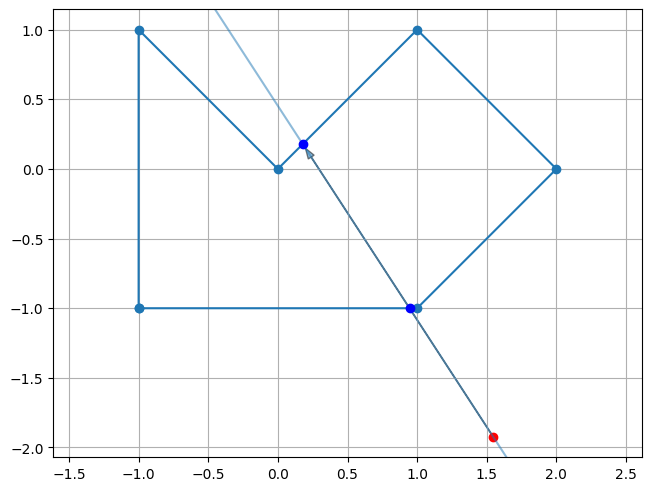

In [ ]:

nodes = np.array([[0,0], [2,0], [3, 1], [2,2], [1,1], [0,2]]) - np.array([1,1])
polygon = Polygon(list(nodes))
point = np.random.uniform(-2, 2, size=2)

fig = plt.figure(
        layout="compressed",
        )

ax = fig.add_subplot(
    1, 1, 1,
    aspect="equal",
)

ax.set_xlim(-3, 3, emit=True)
ax.set_ylim(-3, 3, emit=True)

polygon.draw("o-")

plt.plot(*point, 'or')

is_inner, line, points = is_inner_a(polygon, point, True)

print(f"{is_inner=}, {len(points)=}")

plt.axline(line.P1, line.P2, alpha=0.5)
plt.arrow(*line.P1, *(line.P2-line.P1), head_width=0.05, alpha=0.5)

if len(points)>0:
    ax.plot(*np.stack(points, axis=1), 'ob')



ax.grid()
plt.show()


# Sudoku

## Sudoku tábla `Matplotlib`-bel

A cél sudoku solver megírása. Ma csak megjelenítéssel és feladványok beolvasásával foglakozunk.

Ez egy [project Euler](https://projecteuler.net/problem=96) feladat. A teszt adatok is onnan vannak:

https://projecteuler.net/project/resources/p096_sudoku.txt

In [20]:
grid = [[f"{col}{row}" for col in "ABCDEFGHI"] for row in range(9)]
grid

[['A0', 'B0', 'C0', 'D0', 'E0', 'F0', 'G0', 'H0', 'I0'],
 ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'],
 ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2'],
 ['A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3', 'I3'],
 ['A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4', 'I4'],
 ['A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5', 'I5'],
 ['A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6', 'H6', 'I6'],
 ['A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7', 'H7', 'I7'],
 ['A8', 'B8', 'C8', 'D8', 'E8', 'F8', 'G8', 'H8', 'I8']]

In [21]:
import uuid

class HTMLGrid:
    css = """
        .sudoku-board, .sudoku-board .box, .sudoku-board .box div {
            box-sizing: border-box;
        }

        .sudoku-board, .sudoku-board .box{
            display: flex;
            flex-wrap: wrap;
        }

        .sudoku-board .box {
           border: solid 1px;
           width: 152px;
        }

        .sudoku-board .box > div {
            border: solid 1px;
            width: 50px;
            text-align: center;
        }

        .sudoku-board .box > div:before {
            display: inline-block;
            padding-top: 100%;
            content: '';
            vertical-align: middle;
        }

        .sudoku-board .box .clue {
            background-color: LightGray;
            font-weight: bold;
        }

        .sudoku-board {
            width: 460px;
            margin: 0px;
            font-size: calc(0.8vw + 10px);
            border: solid 2px;
        }

        .sudoku-board .box div {
            color: gray;
            text-shadow: 1px 1px 1px white;
            vertical-align: middle;
        }
    """

    def __init__(self, transform=None):
        self.transform = self._transform if transform is None else transform

    @staticmethod
    def _transform(val):
        if isinstance(val, str):
            return "", val
        if val < 0:
            return 'class="solved"', -val
        elif val == 0:
            return "", ""
        else:
            return 'class="clue"', val

    def box(self, content):
        inner = "".join(f"<div {div_class}>{val}</div>" for div_class, val in content)
        return f'<div class="box">{inner}</div>\n'

    def board(self, boxes):
        inner = "".join(self.box(box) for box in boxes)
        return f'<div class="sudoku-board">\n{inner}</div>\n'

    def __call__(self, grid, title=""):
        boxes = [[0]*9 for _ in range(9)]
        for i, line in enumerate(grid):
          a, ra = divmod(i, 3)
          for j, val in enumerate(line):
            b, rb = divmod(j, 3)
            boxes[a*3+b][ra*3+rb] = self.transform(val)
        header = f"<h3>{title}</h3>" if title else ""
        html = f"<html>\n<head>\n<style>\n{self.css}\n</style>\n</head>\n<body>\n{header}\n{self.board(boxes)}</body></html>"
        html = html.replace('sudoku-board', f'sudoku-board-{uuid.uuid1()!s}')
        return html


Ellenőrzés EXCEL oszlop-sor jelöléssel

In [22]:
from IPython.display import display_html

In [23]:
html_grid = HTMLGrid()
grid = [[f'{j}{i}' for j in "ABCDEFGHI"] for i in range(9)]
html = html_grid(grid, "Grid")
print(html)


<html>
<head>
<style>

        .sudoku-board-03daf13c-b246-11ef-a0da-0242ac1c000c, .sudoku-board-03daf13c-b246-11ef-a0da-0242ac1c000c .box, .sudoku-board-03daf13c-b246-11ef-a0da-0242ac1c000c .box div {
            box-sizing: border-box;
        }

        .sudoku-board-03daf13c-b246-11ef-a0da-0242ac1c000c, .sudoku-board-03daf13c-b246-11ef-a0da-0242ac1c000c .box{
            display: flex;
            flex-wrap: wrap;
        }

        .sudoku-board-03daf13c-b246-11ef-a0da-0242ac1c000c .box {
           border: solid 1px;
           width: 152px;
        }

        .sudoku-board-03daf13c-b246-11ef-a0da-0242ac1c000c .box > div {
            border: solid 1px;
            width: 50px;
            text-align: center;
        }

        .sudoku-board-03daf13c-b246-11ef-a0da-0242ac1c000c .box > div:before {
            display: inline-block;
            padding-top: 100%;
            content: '';
            vertical-align: middle;
        }

        .sudoku-board-03daf13c-b246-11ef-a0da-0

In [24]:

display_html(html, raw=True)


Grid 
 
 A0 B0 C0 A1 B1 C1 A2 B2 C2 
 D0 E0 F0 D1 E1 F1 D2 E2 F2 
 G0 H0 I0 G1 H1 I1 G2 H2 I2 
 A3 B3 C3 A4 B4 C4 A5 B5 C5 
 D3 E3 F3 D4 E4 F4 D5 E5 F5 
 G3 H3 I3 G4 H4 I4 G5 H5 I5 
 A6 B6 C6 A7 B7 C7 A8 B8 C8 
 D6 E6 F6 D7 E7 F7 D8 E8 F8 
 G6 H6 I6 G7 H7 I7 G8 H8 I8

In [25]:

grid=[
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 6, 0, 0, 0, 0, 3],
    [0, 7, 4, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 0, 2],
    [0, 8, 0, 0, 4, 0, 0, 1, 0],
    [6, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 7, 8, 0],
    [5, 0, 0, 0, 0, 9, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 0]
    ]

html = html_grid(grid, "Hard problem")
# print(html)
display_html(html, raw=True)


Hard problem 
 
 2 7 4 
 6 8 
 3 
 8 6 
 3 4 5 
 2 1 
 5 
 1 9 
 7 8 4

In [26]:

from IPython.core.pylabtools import print_figure
import matplotlib.pyplot as plt
from IPython.display import Image, SVG

In [27]:


def figure_data(grid, title="", format="svg"):
    size = len(grid)
    fig = plt.figure(
        figsize=(4, 4),
        layout="compressed",
        )

    ax = fig.add_subplot(
        1, 1, 1,
        aspect="equal",
        xmargin=0.01,
        ymargin=0.01
    )

    ax.axis("off")
    ax.set_title(title, loc="left", fontdict={"weight": "bold"})

    for x, row in enumerate(reversed(grid)):
        for y, value in enumerate(row):
            ax.text(
                y+0.5, x+0.5,
                value,
                ha='center',
                va='center',
                fontsize=12,
                color="gray"
            )

    for x in range(size+1):
        linewidth = 1
        if x % 3 == 0:
            linewidth = 2
        ax.plot((0, size), (x, x), color="black", linewidth=linewidth)
        ax.plot((x, x), (0, size), color="black", linewidth=linewidth)

    data = print_figure(fig, format)
    plt.close(fig)
    return data


In [28]:
# print(figure_data(grid, "Sudoku grid", "png"))

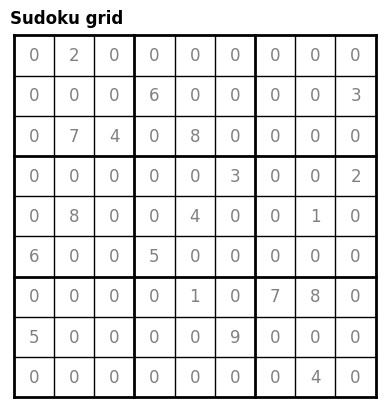

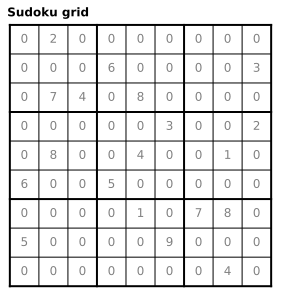

In [29]:
display(Image(figure_data(grid, "Sudoku grid", "png")))
SVG(figure_data(grid, "Sudoku grid", "svg"))

In [ ]:
def char_value(x):
    return int(x) if x.isdigit() else 0

class Sudoku:
    html_grid = HTMLGrid()

    def __init__(self, grid, name=None):
        self.grid = grid
        self.name = name if name is not None else "Unnamed Sudoku"
        self._svg_data = None

    @classmethod
    def from_str(cls, grid, name):
        grid = [[char_value(x) for x in line.strip()] for line in grid]
        return cls(grid, name)

    def enumerate(self):
        grid = self.grid
        for row, line in enumerate(grid, 1):
            for col, value in enumerate(line, 1):
                if value != 0:
                    yield row, col, value

    def copy(self):
        grid = [line.copy() for line in self.grid]
        return type(self)(grid, self.name)

    def as_symbols(self, symbols=" 𝟭𝟮𝟯𝟰𝟱𝟲𝟳𝟴𝟵", neg_symbols=" 123456789"):
        return [
            [symbols[abs(x)] if x>=0 else neg_symbols[abs(x)]  for x in line]
            for line in self.grid
            ]

    def txt(self):
        return '\n'.join(map(' '.join, self.as_symbols("_𝟭𝟮𝟯𝟰𝟱𝟲𝟳𝟴𝟵", "_123456789")))

    def __str__(self):
        return f'{self.name}:\n{self.txt()}'

    # def _repr_html_(self):
    #     return self.html_grid(self.grid, self.name)

    def _repr_svg_(self):
        return self.svg

    @property
    def svg(self):
        if self._svg_data is None:
            fig = self.draw()
            self._svg_data = print_figure(fig, fmt="svg")
        return self._svg_data

    def draw(self, **kwargs):
        grid = self.grid
        size = len(grid)
        ax = plt.subplot(1, 1, 1, aspect="equal")
        ax.axis("off")
        ax.set_title(self.name, loc="left", fontdict={"weight": "bold"})

        text_args = {
            'fontsize': "12",
            'color': "gray",
            'ha': 'center',
            'va': 'center'
            }
        text_args.update(kwargs)
        for row, col, value in self.enumerate():
            row = size-row+1
            if value > 0:
                ax.fill([col-1, col, col, col-1], [row-1, row-1, row, row], color="lightgray", alpha=0.5)

            ax.text(
                col-0.5, row-0.5,
                abs(value),
                **text_args,
                fontweight= "bold" if value > 0 else 'normal'
            )

        for x in range(size+1):
            linewidth = 1
            if x % 3 == 0:
                linewidth = 2
            ax.plot((0, size), (x, x), color="black", linewidth=linewidth)
            ax.plot((x, x), (0, size), color="black", linewidth=linewidth)

        plt.close(ax.figure)

        return ax.figure


### Egy nehéz sudoku

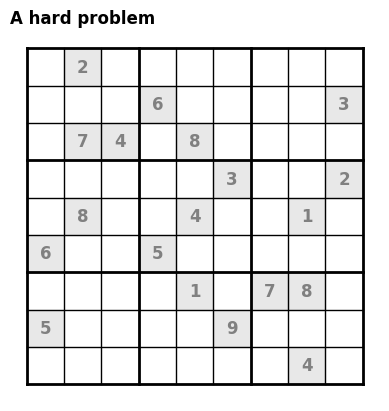

In [31]:
grid=[
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 6, 0, 0, 0, 0, 3],
    [0, 7, 4, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 0, 2],
    [0, 8, 0, 0, 4, 0, 0, 1, 0],
    [6, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 7, 8, 0],
    [5, 0, 0, 0, 0, 9, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 0]
    ]
sudoku = Sudoku(grid, "A hard problem")

sudoku.draw()

A hard problem:
_ 𝟮 _ _ _ _ _ _ _
_ _ _ 𝟲 _ _ _ _ 𝟯
_ 𝟳 𝟰 _ 𝟴 _ _ _ _
_ _ _ _ _ 𝟯 _ _ 𝟮
_ 𝟴 _ _ 𝟰 _ _ 𝟭 _
𝟲 _ _ 𝟱 _ _ _ _ _
_ _ _ _ 𝟭 _ 𝟳 𝟴 _
𝟱 _ _ _ _ 𝟵 _ _ _
_ _ _ _ _ _ _ 𝟰 _


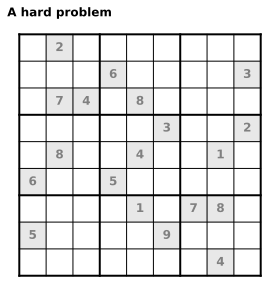

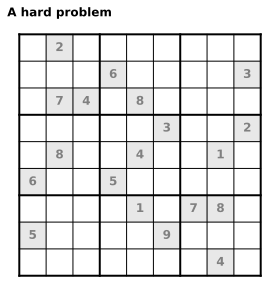

In [ ]:
print(sudoku)
display(sudoku)
display(SVG(sudoku.svg))


In [ ]:
list(sudoku.enumerate())

[(1, 2, 2),
 (2, 4, 6),
 (2, 9, 3),
 (3, 2, 7),
 (3, 3, 4),
 (3, 5, 8),
 (4, 6, 3),
 (4, 9, 2),
 (5, 2, 8),
 (5, 5, 4),
 (5, 8, 1),
 (6, 1, 6),
 (6, 4, 5),
 (7, 5, 1),
 (7, 7, 7),
 (7, 8, 8),
 (8, 1, 5),
 (8, 6, 9),
 (9, 8, 4)]

## Hogyan fogalmazható meg a feladat a matek eszközeivel?

Adottak követelmények (`Item`) és opciók (`Option`). A feladat az opciók egy részének kiválasztása úgy, hogy az összes követelmény teljesüljön.

Egy lehetséges formalizálás, $x_1,\dots, x_m$ logikai változók, egy
$c=c(x_1,\dots,x_n)$ logikai kifejezés.

A kérdés ezután az, hogy az $x_i$ értékek (Igaz/Hamis) milyen választása mellett lesz a $c$ logikai kifejezés értéke igaz.

Minden logikai kifejezés felírható $\wedge$ (és) $\vee$ (vagy) és $\neg$ (tagadás) segítségével.

pl.
$$
    x_1\Rightarrow x_2,\quad \neg x_1\vee x_2
$$

A logikai kifejezés $c$ megadható olyan alakban is, ahol
$$
    c(x_1,\dots, x_m) = \large\wedge_i c_i(x_1,\dots,x_m)\quad
    c_i(x_1,\dots,x_m) = (\vee_{j\in S_i} x_j) \vee (\vee_{j\in S'_i} \neg x_j),\quad S,S'\subset\{1,\dots, m\}
$$

$c_i$ megadható $S$ és $S'$ segítségével. Ha $S_i\cap S'_i\neq \emptyset$ akkor $c_i$ mindig igaz, ezért $c$-ből elhagyható. Ha a váltózók indexelése 1-től indul, akkor egy kényelmes kódolása $c_i$-nek
az indexek előjeles listája:
$$
    \{j:j \in S_i\}\cup\{-j:j\in S'_i\}
$$


## Sudoku tábla

In [32]:
class Option(int):
    max_value = 9*9*9

    def __init__(self, val):
        if not (1 <= abs(val) <= self.max_value):
            raise ValueError(f"Absolute value must be in [1, {self.max_value}]. Obtained {val}")

    def apply(self, grid):
        row, col, val = self.to_triple()
        row, col = row-1, col-1
        if grid[row][col] != 0 and abs(grid[row][col]) != val:
            raise ValueError("Grid cell at {row+1}, {col+1} is not empty!")
        if grid[row][col] == 0:
            grid[row][col] = val

    @classmethod
    def from_triple(cls, row, col, val):
        if not (1<= row <= 9 and 1<= col <= 9 and 1<= val <= 9):
            raise ValueError(
                "Invalid triple. "
                "All numbers must be in [1, 9]. "
                f"Obtained {row=}, {col=}, {val=}"
                )
        return cls((row-1)*81+(col-1)*9+val-1 + 1)

    @classmethod
    def instances(cls):
        for i in range(1, cls.max_value+1):
            yield cls(i)

    def to_triple(self):
        n = abs(self)-1
        n, val = divmod(n, 9)
        row, col = divmod(n, 9)
        row, col, val = row+1, col+1, val+1
        return row, col, val

    def __neg__(self):
        return Option(-int(self))

    def __str__(self):
        row, col, val = self.to_triple()
        prefix = 'not ' if self < 0 else ''
        return f"{prefix}{val}@({row}, {col})"

    def __repr__(self):
        return f"{type(self).__name__}({self!s}, code={self:d})"

    def items(self):
        row, col, val = self.to_triple()
        yield Item.not_empty(row, col)
        yield Item.row_contains(row, val)
        yield Item.col_contains(col, val)
        yield Item.square_contains(row, col, val)


class Clause(list):
    def __str__(self):
        return ' or '. join(map(str, self))

In [33]:
%%ipytest
from pytest import raises

def test_option():
    for i in range(1, 10):
        for j in range(1, 10):
            for val in range(1,10):
                option = Option.from_triple(i, j, val)
                assert str(option) == f"{val}@({i}, {j})"
                assert option.to_triple() == (i, j, val)

def test_option_invalid():
    with raises(ValueError):
        option = Option.from_triple(10,9,9)

    with raises(ValueError):
        option = Option.from_triple(0,9,9)

    with raises(ValueError):
        option = Option.from_triple(1,10,9)

    with raises(ValueError):
        option = Option.from_triple(1,0,9)

    with raises(ValueError):
        option = Option.from_triple(1,9,19)

    with raises(ValueError):
        option = Option.from_triple(1,9,0)

def test_option_all():
    for i, o in enumerate(Option.instances(), 1):
        assert o == i
    assert i == Option.max_value



...                                                                                          [100%]
3 passed in 0.02s


In [34]:
-Option.from_triple(1,1,9)

Option(not 9@(1, 1), code=-9)

In [38]:
from pprint import pprint

In [39]:
def subsquare(i, j):
    x, y = 3*i+1, 3*j+1
    for row in range(x, x+3):
        for col in range(y, y+3):
            yield row, col

class Item(int):
    max_value = 4*9*9-1


    def __init__(self, value):
        if not (0 <= value <= self.max_value):
            raise ValueError(f"Value must be in [0, max_value]. Obtained {value}")

    @classmethod
    def from_triple(cls, item_type, a, b):
        if not (0 <= item_type < 4 and 0 <= a < 9 and 0 <= b < 9):
            raise ValueError(f"Invalid parameters: {item_type=}, {a=}, {b=}")
        return cls(item_type*81+a*9+b)

    @classmethod
    def not_empty(cls, row, col):
        return cls.from_triple(0, row-1, col-1)

    @classmethod
    def row_contains(cls, row, val):
        return cls.from_triple(1, row-1, val-1)

    @classmethod
    def col_contains(cls, col, val):
        return cls.from_triple(2, col-1, val-1)

    @classmethod
    def square_contains(cls, row, col, val):
        sq = 3*((row-1)//3) + ((col-1)//3)
        return cls.from_triple(3, sq, val-1)

    @classmethod
    def instances(cls):
        for i in range(cls.max_value+1):
            yield cls(i)

    def __str__(self):
        n = self
        item_type, n = divmod(n, 81)
        i, j = divmod(n, 9)
        match item_type:
            case 0:
                return f"cell{(i+1, j+1)} ¬∅"
            case 1:
                return f"∃{j+1} in row[{i+1}]"
            case 2:
                return f"∃{j+1} in col[{i+1}]"
            case 3:
                val = j+1
                i, j = divmod(i, 3)
                return f"∃{val} in square{(i+1, j+1)}"

    def __repr__(self):
        return f"{type(self).__name__}({self!s}, code={self:d})"

    def options(self):
        n = self
        item_type, n = divmod(n, 81)
        i, j = divmod(n, 9)
        match item_type:
            case 0:
                row, col = i+1, j+1
                for val in range(1, 10):
                    yield Option.from_triple(row, col, val)
            case 1:
                row = i+1
                val = j+1
                for col in range(1, 10):
                    yield Option.from_triple(row, col, val)
            case 2:
                val = j+1
                col = i+1
                for row in range(1, 10):
                    yield Option.from_triple(row, col, val)
            case 3:
                val = j+1
                i, j = divmod(i, 3)
                for row,col in subsquare(i, j):
                    yield Option.from_triple(row, col, val)

    def cnf(self):
        return Clause(self.options())


In [40]:

item = Item(81*3+45)
print(f"{item=}")
print(item.cnf())
pprint(set(item.options()))
print(f"{len(list(Item.instances()))=}")

item=Item(∃1 in square(2, 3), code=288)
1@(4, 7) or 1@(4, 8) or 1@(4, 9) or 1@(5, 7) or 1@(5, 8) or 1@(5, 9) or 1@(6, 7) or 1@(6, 8) or 1@(6, 9)
{Option(1@(4, 7), code=298),
 Option(1@(4, 8), code=307),
 Option(1@(4, 9), code=316),
 Option(1@(5, 7), code=379),
 Option(1@(5, 8), code=388),
 Option(1@(5, 9), code=397),
 Option(1@(6, 7), code=460),
 Option(1@(6, 8), code=469),
 Option(1@(6, 9), code=478)}
len(list(Item.instances()))=324


In [ ]:
print(Clause([Option(1), Option(2), -Option(3)]))

1@(1, 1) or 2@(1, 1) or not 3@(1, 1)


In [ ]:
option = Option(100)
print(f"{option=}")
pprint(list(option.items()))

option=Option(1@(2, 3), code=100)
[Item(cell(2, 3) ¬∅, code=11),
 Item(∃1 in row[2], code=90),
 Item(∃1 in col[3], code=180),
 Item(∃1 in square(1, 1), code=243)]


## Sudoku solver a `picosat` könyvtárral.

A következő kód a `picosat` solver `github` repositorijáról van:

https://pypi.org/project/pycosat/

https://github.com/conda/pycosat/blob/main/examples/sudoku.py

```python
"""
The implementation of this Sudoku solver is based on the paper:

    "A SAT-based Sudoku solver" by Tjark Weber

    https://www.lri.fr/~conchon/mpri/weber.pdf

If you want to understand the code below, in particular the function valid(),
which calculates the 324 clauses corresponding to 9 cells, you are strongly
encouraged to read the paper first.  The paper is very short, but contains
all necessary information.
"""
import pycosat


def v(i, j, d):
    """
    Return the number of the variable of cell i, j and digit d,
    which is an integer in the range of 1 to 729 (including).
    """
    return 81 * (i - 1) + 9 * (j - 1) + d


def sudoku_clauses():
    """
    Create the (11745) Sudoku clauses, and return them as a list.
    Note that these clauses are *independent* of the particular
    Sudoku puzzle at hand.
    """
    res = []
    # for all cells, ensure that the each cell:
    for i in range(1, 10):
        for j in range(1, 10):
            # denotes (at least) one of the 9 digits (1 clause)
            res.append([v(i, j, d) for d in range(1, 10)])
            # does not denote two different digits at once (36 clauses)
            for d in range(1, 10):
                for dp in range(d + 1, 10):
                    res.append([-v(i, j, d), -v(i, j, dp)])

    def valid(cells):
        # Append 324 clauses, corresponding to 9 cells, to the result.
        # The 9 cells are represented by a list tuples.  The new clauses
        # ensure that the cells contain distinct values.
        for i, xi in enumerate(cells):
            for j, xj in enumerate(cells):
                if i < j:
                    for d in range(1, 10):
                        res.append([-v(xi[0], xi[1], d), -v(xj[0], xj[1], d)])

    # ensure rows and columns have distinct values
    for i in range(1, 10):
        valid([(i, j) for j in range(1, 10)])
        valid([(j, i) for j in range(1, 10)])
    # ensure 3x3 sub-grids "regions" have distinct values
    for i in 1, 4, 7:
        for j in 1, 4 ,7:
            valid([(i + k % 3, j + k // 3) for k in range(9)])

    assert len(res) == 81 * (1 + 36) + 27 * 324
    return res


def solve(grid):
    """
    solve a Sudoku grid inplace
    """
    clauses = sudoku_clauses()
    for i in range(1, 10):
        for j in range(1, 10):
            d = grid[i - 1][j - 1]
            # For each digit already known, a clause (with one literal).
            # Note:
            #     We could also remove all variables for the known cells
            #     altogether (which would be more efficient).  However, for
            #     the sake of simplicity, we decided not to do that.
            if d:
                clauses.append([v(i, j, d)])

    # solve the SAT problem
    sol = set(pycosat.solve(clauses))

    def read_cell(i, j):
        # return the digit of cell i, j according to the solution
        for d in range(1, 10):
            if v(i, j, d) in sol:
                return d

    for i in range(1, 10):
        for j in range(1, 10):
            grid[i - 1][j - 1] = read_cell(i, j)


if __name__ == '__main__':
    from pprint import pprint

    # hard Sudoku problem, see Fig. 3 in paper by Weber
    hard = [[0, 2, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 6, 0, 0, 0, 0, 3],
            [0, 7, 4, 0, 8, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 3, 0, 0, 2],
            [0, 8, 0, 0, 4, 0, 0, 1, 0],
            [6, 0, 0, 5, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 7, 8, 0],
            [5, 0, 0, 0, 0, 9, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 4, 0]]
    solve(hard)
    pprint(hard)
    assert [[1, 2, 6, 4, 3, 7, 9, 5, 8],
            [8, 9, 5, 6, 2, 1, 4, 7, 3],
            [3, 7, 4, 9, 8, 5, 1, 2, 6],
            [4, 5, 7, 1, 9, 3, 8, 6, 2],
            [9, 8, 3, 2, 4, 6, 5, 1, 7],
            [6, 1, 2, 5, 7, 8, 3, 9, 4],
            [2, 6, 9, 3, 1, 4, 7, 8, 5],
            [5, 4, 8, 7, 6, 9, 2, 3, 1],
            [7, 3, 1, 8, 5, 2, 6, 4, 9]] == hard

```

In [41]:
! pip install pycosat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycosat: filename=pycosat-0.6.6-cp310-cp310-linux_x86_64.whl size=169341 sha256=494b0d4c8b35ffd06be2a828b4254ff49c78f5024c480d75e172f394f57f9c26
  Stored in directory: /root/.cache/pip/wheels/63/29/df/b8c22ca5812e2d7b342269a53add280b5bad42a540f34c3dc1
Successfully built pycosat


In [43]:
import pycosat
from itertools import product, combinations


In [44]:
def sudoku_clauses_naive():
    one_value_per_cell = [
        Clause((-Option.from_triple(row, col, val0), -Option.from_triple(row, col, val1)))
        for row, col, (val0, val1) in product(
            range(1, 10),
            range(1, 10),
            combinations(range(1, 10), 2)
        )
    ]

    return (
        [Item(i).cnf() for i in range(4*81)] +
        one_value_per_cell
    )

In [45]:

def sudoku_clauses():
    one_value_per_cell = [
        Clause((-Option.from_triple(row, col, val0), -Option.from_triple(row, col, val1)))
        for row, col, (val0, val1) in product(
            range(1, 10),
            range(1, 10),
            combinations(range(1, 10), 2)
        )
    ]

    one_location_per_row = [
        Clause((-Option.from_triple(row, col0, val), -Option.from_triple(row, col1, val)))
        for row, (col0, col1), val in product(
            range(1, 10),
            combinations(range(1, 10), 2),
            range(1, 10),
        )
    ]

    one_location_per_col = [
        Clause((-Option.from_triple(row0, col, val), -Option.from_triple(row1, col, val)))
        for (row0, row1), col, val in product(
            combinations(range(1, 10), 2),
            range(1, 10),
            range(1, 10)
        )
    ]

    one_location_per_square = [
        Clause((-Option.from_triple(row0, col0, val), -Option.from_triple(row1, col1, val)))
        for i in range(9)
        for ((row0, col0), (row1, col1)), val in product(
            combinations(subsquare(i//3, i%3), 2),
            range(1, 10)
        )
    ]

    return (
        [Item(i).cnf() for i in range(4*81)] +
        one_value_per_cell +
        one_location_per_row +
        one_location_per_col +
        one_location_per_square
    )

In [46]:
clauses = sudoku_clauses_naive()
print(f"naive: {len(clauses)=}\n{clauses[0]=!s}\n{clauses[-5]=!s}")
clauses = sudoku_clauses()
print(f"improved: {len(clauses)=}\n{clauses[0]=!s}\n{clauses[-5]=!s}")


naive: len(clauses)=3240
clauses[0]=1@(1, 1) or 2@(1, 1) or 3@(1, 1) or 4@(1, 1) or 5@(1, 1) or 6@(1, 1) or 7@(1, 1) or 8@(1, 1) or 9@(1, 1)
clauses[-5]=not 6@(9, 9) or not 8@(9, 9)
improved: len(clauses)=11988
clauses[0]=1@(1, 1) or 2@(1, 1) or 3@(1, 1) or 4@(1, 1) or 5@(1, 1) or 6@(1, 1) or 7@(1, 1) or 8@(1, 1) or 9@(1, 1)
clauses[-5]=not 5@(9, 8) or not 5@(9, 9)


In [47]:
def naive_solver(sudoku, **kwargs):
    """
    solve a Sudoku grid inplace
    """
    clauses = sudoku_clauses_naive()

    clauses.extend(
        Clause([Option.from_triple(row, col, val)])
        for row, col, val in sudoku.enumerate()
    )

    sudoku_solved = sudoku.copy()
    grid = sudoku_solved.grid
    for option in pycosat.solve(clauses, **kwargs):
        if option > 0:
            Option(option).apply(grid)
    sudoku_solved.name += " solved"
    return sudoku_solved

In [48]:
def modified_solver(sudoku, **kwargs):
    """
    solve a Sudoku grid inplace
    """
    clauses = sudoku_clauses()

    clauses.extend(
        Clause([Option.from_triple(row, col, val)])
        for row, col, val in sudoku.enumerate()
    )

    sudoku_solved = sudoku.copy()
    grid = sudoku_solved.grid
    for option in pycosat.solve(clauses, **kwargs):
        if option > 0:
            Option(option).apply(grid)
    sudoku_solved.name += " solved"
    return sudoku_solved


In [49]:
class PycosatSolver:
    naive_clauses = sudoku_clauses_naive()
    clauses = sudoku_clauses()
    def solve(self, sudoku, which="modified", **kwargs):
        clauses = self.clauses if which == "modified" else self.naive_clauses
        clauses = clauses.copy()
        clauses.extend(
            Clause([Option.from_triple(row, col, val)])
            for row, col, val in sudoku.enumerate()
        )
        sudoku_solved = sudoku.copy()
        grid = sudoku_solved.grid
        for option in pycosat.solve(clauses, **kwargs):
            if option > 0:
                Option(option).apply(grid)
        sudoku_solved.name += " solved"
        return sudoku_solved



In [50]:
%timeit sudoku_solved = naive_solver(sudoku)

1.17 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%timeit sudoku_solved = modified_solver(sudoku)

43.9 ms ± 680 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
sudoku_solved = modified_solver(sudoku)
print(sudoku_solved)

A hard problem solved:
𝟭 𝟮 𝟲 𝟰 𝟯 𝟳 𝟵 𝟱 𝟴
𝟴 𝟵 𝟱 𝟲 𝟮 𝟭 𝟰 𝟳 𝟯
𝟯 𝟳 𝟰 𝟵 𝟴 𝟱 𝟭 𝟮 𝟲
𝟰 𝟱 𝟳 𝟭 𝟵 𝟯 𝟴 𝟲 𝟮
𝟵 𝟴 𝟯 𝟮 𝟰 𝟲 𝟱 𝟭 𝟳
𝟲 𝟭 𝟮 𝟱 𝟳 𝟴 𝟯 𝟵 𝟰
𝟮 𝟲 𝟵 𝟯 𝟭 𝟰 𝟳 𝟴 𝟱
𝟱 𝟰 𝟴 𝟳 𝟲 𝟵 𝟮 𝟯 𝟭
𝟳 𝟯 𝟭 𝟴 𝟱 𝟮 𝟲 𝟰 𝟵


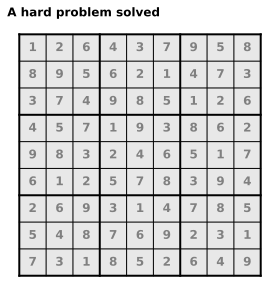

In [ ]:
display(SVG(sudoku_solved.svg))

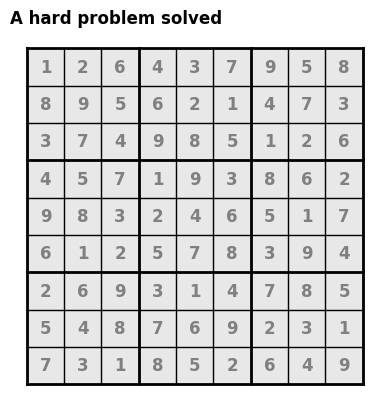

In [ ]:
sudoku_solved.draw()

## Egész értékű programozás

A sudoku feladat úgy is megfogalmazható, hogy adott egy mátrix $A$. $A_{i,j}=1$ ha az $j$. opció kielégíti a $i$. követelményt. A korábbi $x_1,\dots,x_m$ logikai változókat egy $x$ vektorba összefogva ($\text{Hamis}=0$ és $\text{Igaz}=1$)
$$
    v = Ax
$$
esetén $v_i$ azt adja meg, hogy a $i$. követelményt hány opció teljesíti a kiválasztottak közül. Azt szeretnénk, ha ez 1 lenne minden $i$-re.

Azaz a feladat
$$
    Ax = \mathbb{1}, \quad \text{úgy, hogy  $x_i\in\{0, 1\}$}
$$
Ha több megoldás van akkor vehetjük azt, ami minimalizál egy lineráris kifejezést.

## Lineáris programozás

A lineáris programozási feladat általános alakja:
$$
    x_0=\arg\max_x c^T x,\quad\text{úgy, hogy}\quad
    Ax \leq b, \quad x\geq0
$$
Azaz azt az $x_0$ vektort keressük, ami a $\sum_jc_jx_j$ összeget maximalizálja azon nem negatív koordinátájú $x$-ek között, amik a lineáris feltételnek $(Ax)_j\geq 0$ eleget tesznek.

A feladatban $A$, $c$ és $b$ adottak és $c$, $b$ **nem negatívak** (azaz a koordináták ilyenek).

Példa:

In [53]:
import numpy as np
import matplotlib.pyplot as plt

In [54]:
c = np.array([1, 1])
b = np.array([2, 3])
A = np.array([[1, 2], [2, 1]])
print(f"{c=}, {b=},\n{A=!s}")

c=array([1, 1]), b=array([2, 3]),
A=[[1 2]
 [2 1]]


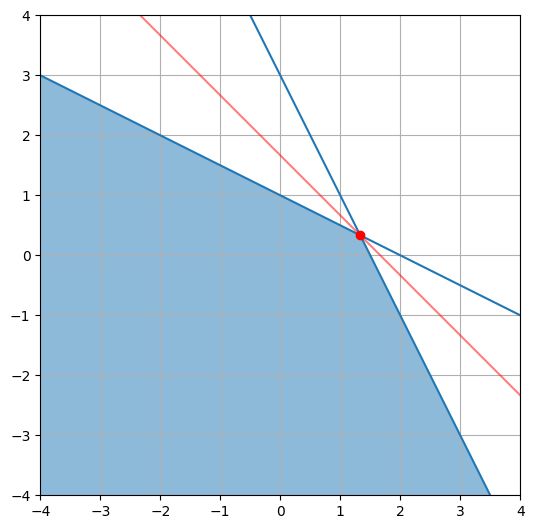

In [55]:
def line(v, b):
    p0 = b/(v@v)*v
    v_perp = np.array([v[1], -v[0]])
    p1 = p0+v_perp
    return p0, p1

def y_fun(v, b):
    return lambda x: b/v[1]-(v[0]/v[1])*x

ax = plt.axes((0, 0, 1, 1))
ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4))
ax.set_aspect("equal")
for v, b0 in zip(A, b):
    ax.axline(*line(v, b0))
ax.grid()
ax.plot([4/3], [1/3], 'or')
ax.axline((4/3, 1/3), (1/3, 4/3), color='red', alpha=0.5)


xs = np.linspace(-4, 4, 201)

ax.fill_between(xs, -4, np.minimum(y_fun(A[0], b[0])(xs), y_fun(A[1], b[1])(xs)), alpha=0.5)
plt.show()


## `scipy` mixed integer solver (`milp`).

In [56]:
from scipy.optimize import milp, Bounds, LinearConstraint
import numpy as np

In [ ]:
help(milp)

Help on function milp in module scipy.optimize._milp:

milp(c, *, integrality=None, bounds=None, constraints=None, options=None)
    Mixed-integer linear programming
    
    Solves problems of the following form:
    
    .. math::
    
        \min_x \ & c^T x \\
        \mbox{such that} \ & b_l \leq A x \leq b_u,\\
        & l \leq x \leq u, \\
        & x_i \in \mathbb{Z}, i \in X_i
    
    where :math:`x` is a vector of decision variables;
    :math:`c`, :math:`b_l`, :math:`b_u`, :math:`l`, and :math:`u` are vectors;
    :math:`A` is a matrix, and :math:`X_i` is the set of indices of
    decision variables that must be integral. (In this context, a
    variable that can assume only integer values is said to be "integral";
    it has an "integrality" constraint.)
    
    Alternatively, that's:
    
    minimize::
    
        c @ x
    
    such that::
    
        b_l <= A @ x <= b_u
        l <= x <= u
        Specified elements of x must be integers
    
    By default, ``l = 

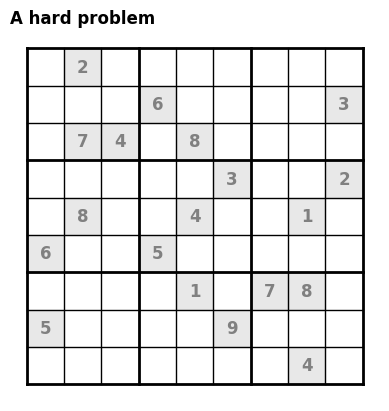

In [ ]:
sudoku.draw()

In [57]:
def sudoku_adj_matrix():
    options = list(Option.instances())

    A = np.zeros((Item.max_value+1, len(options)))
    for j, option in enumerate(options):
        for item in option.items():
            A[item][j] = 1
    return A, options


In [59]:
A, options = sudoku_adj_matrix()
pprint(A)
A.shape

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])


(324, 729)

In [60]:

class MilpSolver():
    A, options = sudoku_adj_matrix()
    options_ub = np.ones_like(options)
    items_b = np.ones(A.shape[0])

    def solve(self, sudoku):
        lower_bound = np.zeros_like(self.options_ub)

        lower_bound[
            [Option.from_triple(row, col, val)-1 for row, col, val in sudoku.enumerate()]
            ] = 1
        bounds = Bounds(lower_bound, self.options_ub)
        constraints = LinearConstraint(self.A, self.items_b, self.items_b)
        solution = milp(
            self.options_ub, # all one vector, could be almost anything
            integrality=self.options_ub,
            bounds=bounds,
            constraints=constraints
            )
        sudoku_solved = sudoku.copy()
        sudoku_solved.name += " solved"
        for option, include in zip(self.options, solution.x):
            if include == 1:
                option.apply(sudoku_solved.grid)

        sudoku_solved.milp_solution = solution
        return sudoku_solved





In [61]:
milp_solver = MilpSolver()
sudoku_solved = milp_solver.solve(sudoku)

In [62]:
%timeit sudoku_solved = milp_solver.solve(sudoku)


12 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 81.0
              x: [ 1.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
 mip_node_count: 0
 mip_dual_bound: 81.0
        mip_gap: 0.0


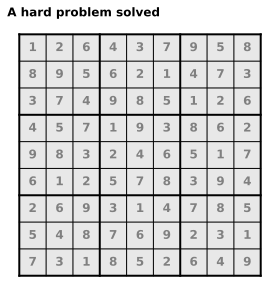

In [63]:
print(sudoku_solved.milp_solution)
sudoku_solved

In [ ]:
print(sudoku_solved)

A hard problem solved:
𝟭 𝟮 𝟲 𝟰 𝟯 𝟳 𝟵 𝟱 𝟴
𝟴 𝟵 𝟱 𝟲 𝟮 𝟭 𝟰 𝟳 𝟯
𝟯 𝟳 𝟰 𝟵 𝟴 𝟱 𝟭 𝟮 𝟲
𝟰 𝟱 𝟳 𝟭 𝟵 𝟯 𝟴 𝟲 𝟮
𝟵 𝟴 𝟯 𝟮 𝟰 𝟲 𝟱 𝟭 𝟳
𝟲 𝟭 𝟮 𝟱 𝟳 𝟴 𝟯 𝟵 𝟰
𝟮 𝟲 𝟵 𝟯 𝟭 𝟰 𝟳 𝟴 𝟱
𝟱 𝟰 𝟴 𝟳 𝟲 𝟵 𝟮 𝟯 𝟭
𝟳 𝟯 𝟭 𝟴 𝟱 𝟮 𝟲 𝟰 𝟵


## Google `OR-tools` (operation research tools)

In [ ]:
import importlib
if importlib.util.find_spec('ortools') is None:
    ! pip install ortools


Ezzel is megoldhatnánk. HF.

## Feladványok a netről

In [64]:
import urllib

In [65]:
dowload_large = False #or True

url50 = "https://projecteuler.net/project/resources/p096_sudoku.txt"

urllib.request.urlretrieve(url50, "/tmp/sudoku.txt")


url50000 = "https://github.com/t-dillon/tdoku/raw/master/data.zip"

if dowload_large:
    urllib.request.urlretrieve(url50000, "/tmp/sudoku-large.zip")



In [67]:
! head -n 20 /tmp/sudoku.txt

Grid 01
003020600
900305001
001806400
008102900
700000008
006708200
002609500
800203009
005010300
Grid 02
200080300
060070084
030500209
000105408
000000000
402706000
301007040
720040060
004010003


In [ ]:
if dowload_large:
    ! unzip -l /tmp/sudoku-large.zip
    ! unzip -q /tmp/sudoku-large.zip data/puzzles2_17_clue

In [ ]:
def drop_comment(file):
    while True:
        try:
            line = next(file).strip()
        except EOFError:
            return
        if not line.startswith("#"):
            yield line

In [ ]:
if dowload_large:
    with open('data/puzzles2_17_clue', 'r') as file:
        line = next(drop_comment(file))
        grid = [[int(ch) if ch.isdigit() else 0 for ch in line[i: i+9]] for i in range(0,81,9)]
        sudoku = Sudoku(grid)
    sudoku

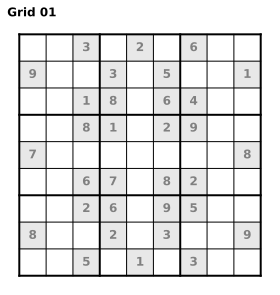

In [69]:
with open('/tmp/sudoku.txt') as f:
    name = f.readline().strip()
    grid = [f.readline() for _ in range(9)]
    sudoku = Sudoku.from_str(grid, name)

sudoku

In [70]:
def read_sudokus(filename):
    with open(filename, "r") as file:
        lines = iter(file)
        while True:
            try:
                name = next(lines).strip()
                grid = [next(lines) for _ in range(9)]
            except StopIteration:
                break
            yield Sudoku.from_str(grid, name)

In [71]:
from tqdm.auto import tqdm

In [73]:
sudokus = list(read_sudokus("/tmp/sudoku.txt"))

In [74]:
%%time

sudoku_milp = MilpSolver()
solved_milp = [sudoku_milp.solve(sudoku) for sudoku in tqdm(sudokus)]


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 286 ms, sys: 3.75 ms, total: 290 ms
Wall time: 310 ms


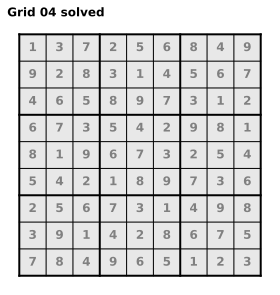

In [75]:
solved_milp[3]

In [76]:
sudokus = list(read_sudokus("/tmp/sudoku.txt"))

In [77]:
%%time

pycosat_solver = PycosatSolver()
solved_picosat = [pycosat_solver.solve(sudoku) for sudoku in tqdm(sudokus)]



  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 196 ms, sys: 1.71 ms, total: 198 ms
Wall time: 205 ms


In [78]:
sudokus = list(read_sudokus("/tmp/sudoku.txt"))

In [79]:
%%time

pycosat_solver = PycosatSolver()
solved_naive = [pycosat_solver.solve(sudoku, "naive") for sudoku in tqdm(sudokus)]


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 6.67 s, sys: 20.6 ms, total: 6.69 s
Wall time: 6.84 s


## Saját solver


A Sudokuban ki kell tölteni a hiányzó mezőket úgy, hogy minden sor, oszlop és a 9 db 3x3-as négyzet mindegyike tartalmazza az összes számot egytől kilencig.

Minden oszlop, sor és kis négyzet kilenc követelményt jelent nevezetesen azt, hogy az adott tábla részen kell, hogy legyen $1,...,9$.
Ez összesen $3*9*9$ követelmény. További követlemény, hogy minden mező pontosan egy értéket tartalmazhat. Ez további 81 követelmény, így összesen $4*9*9$
követelmény van.

Minden cellába írhatjuk a 9 szám bármelyikét ez összesen $9*9*9$ opció.

Minden opció ki tud elégíteni néhány követelményt, pl. ha az opció az hogy (1,1) mezőben 2 van, akkor ha ezt az opciót kiválasztjuk, azzal teljesülni fog,
hogy az első sorban, első oszlopban és az (1,1) tartalmazó 3x3-as négyzetben is van 2-es.

A feladványt, akkor oldottuk meg, ha kiválasztottuk az opciók egy részét úgy, hogy minden követelményt pontosan egy opció teljesít a kiválasztottak közül.


Kicsit messzebről ránézve, van egy páros gráfunk. A csúcsok egyik csoportja a követelményekből, a másik az opciókból áll. Egy követelmény és egy opció között akkor megy él, ha az adott opció kiválasztásával kielégítjük a követelményt.

A cél opciók egy részének kiválasztása úgy, hogy minden követelménynek pontosan egy szomszédja legyen a kiválasztott opciók között (exact cover).

A megoldás megtalálása elméletben egyszerű.

1. `G` a játék gráfja (mátrixa). Töröljük azokat az opciókat, amik összegyeztethetelenek a kitöltött mezőkkel.
2. Válasszunk egy `item` követelményt.
3. A `item` szomszédjait ellenőrizzük le. Azaz menjünk végig azokon az opciókon, amik `item`-et kielégítik:
   
   - Mindegyik opcióra  készítsük el azt a  kisebb gráfot, amit úgy kapunk, hogy a kiválasztott opciót
     beírjuk a táblába.
   
     Így néhány további követelményt is kielégítünk és néhány opciót el is kell hagynunk.

   - Oldjuk meg a kisebb gráffal a feladatot:
     
     Ha a kisebb feladatnak nincs megoldása, a kiválasztott opcióval nem lehet megoldani a problémát.
     Nézzük a következő lehetőséget.

     Ha a kisebb feladatnak van megoldása, akkor a feladat megoldása a kiválasztott opció és a kisebb probléma megoldása együtt.

Lehet, hogy kóddal leírva könnyebben érthető.

```python
def search(G):
    if G.items:
      item = first_item(G.items)
      for option in G.options[item]:
            solution = search(new_graph(G, option))
            if solution is not None:
                return (option,) + solution
      return None
    return tuple()
```

Itt `new_graph(G, option)` visszaadja a gráfot amit úgy kapunk, hogy
`option` által kielégített követelményeket  és azokat az opciókat amik `option`-nal összeegyeztethetlenek elhagyjuk.

Azt feltételezzük, hogy a `new_graph` függvény nem módosítja `G`-t a visszaadott gráf másolat.


A futási idő attól függ, hogyan választjuk ki követelményt. A legegyszerűbb módszer: vegyük azt amihez aktuálisan a legkevesebb opció tartozik.
Ez pont annak felel meg, amit a játék során magunk is csinálnánk, pl ha egy mezőbe csak egy lehetőség maradt az kitöltjük.

In [81]:
def sudoku_graph():
    options = {
        option: list(option.items())
        for option in Option.instances()
    }
    items = {
        item: set(item.options())
        for item in Item.instances()
    }
    return options, items


def new_graph(graph, option):
    options, items = graph
    items_covered = [
        item for item in options[option] if item in items
    ]
    conflicting_options = {
        o for item in items_covered for o in items[item]
    }
    new_options = {
        key: [
            item for item in value if item not in items_covered]
        for key, value in options.items()
        if key not in conflicting_options
    }
    new_items = {
        key: {
            opt for opt in value if opt not in conflicting_options
        }
        for key, value in items.items()
        if key not in items_covered
    }
    return new_options, new_items

def first_item(items):
    return min(items, key=lambda item: len(items[item]))

def search(graph):
    _, items = graph
    if items:
        item = first_item(items)
        for option in items[item]:
            solution = search(new_graph(graph, option))
            if solution is not None:
                return (option,) + solution
        return None
    return tuple()

def initial_graph(sudoku):
    graph = sudoku_graph()
    for row, col, val in sudoku.enumerate():
        option = Option.from_triple(row, col, val)
        graph = new_graph(graph, option)
    return graph

def sudoku_solver(sudoku):
    graph = initial_graph(sudoku)

    solution = search(graph)
    if solution is None:
        return None

    sudoku_solved = sudoku.copy()
    for option in solution:
        option.apply(sudoku_solved.grid)
    return sudoku_solved


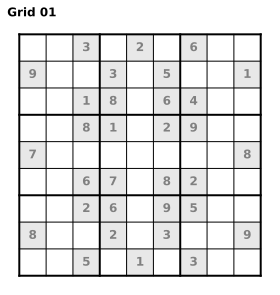

In [82]:
sudoku

In [83]:
options, items = initial_graph(sudoku)

In [ ]:
# pprint(items)

In [84]:

%timeit sudoku_solved = sudoku_solver(sudoku)

51 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


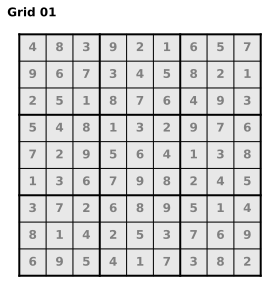

In [ ]:
sudoku_solved = sudoku_solver(sudoku)
sudoku_solved

### Logging. Megoldás lépésről lépésre

In [ ]:
import logging

logging.BASIC_FORMAT

'%(levelname)s:%(name)s:%(message)s'

In [85]:
import logging
logger = logging.getLogger('sudoku')
logging.basicConfig(format="%(message)s", force=True)
logger.setLevel(logging.WARNING)


In [86]:

def search(graph, level=0):
    _, items = graph
    if items:
        item = first_item(items)
        logger.info(
            'level %3d: considering %s with %d options',
            level, item, len(items[item]))

        for option in items[item]:
            logger.info(
                'level %3d: trying %s for %s',
                level, option, item)
            solution = search(new_graph(graph, option), level+1)
            if solution is not None:
                logger.info('level %3d: %s works', level, option)
                return (option,) + solution
            logger.info('level %3d: %s rejected', level, option)
        return None
    return tuple()

In [ ]:
# logger.setLevel(logging.DEBUG)

In [88]:
from contextlib import contextmanager

@contextmanager
def using_level(level):
    logger = logging.getLogger('sudoku')
    _level = logger.level
    try:
        logger.setLevel(level)
        yield
    finally:
        logger.setLevel(_level)

In [89]:
sudoku_solved = sudoku_solver(sudoku)


In [ ]:
grid=[
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 6, 0, 0, 0, 0, 3],
    [0, 7, 4, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 0, 2],
    [0, 8, 0, 0, 4, 0, 0, 1, 0],
    [6, 0, 0, 5, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 7, 8, 0],
    [5, 0, 0, 0, 0, 9, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 0]
    ]
sudoku = Sudoku(grid, "A hard problem")

fig=sudoku.draw()
# fig.savefig('/tmp/hard.png')


In [90]:
with using_level(logging.INFO):
    sudoku_solved = sudoku_solver(sudoku)


level   0: considering cell(5, 6) ¬∅ with 1 options
level   0: trying 4@(5, 6) for cell(5, 6) ¬∅
level   1: considering cell(5, 3) ¬∅ with 1 options
level   1: trying 9@(5, 3) for cell(5, 3) ¬∅
level   2: considering cell(5, 4) ¬∅ with 1 options
level   2: trying 5@(5, 4) for cell(5, 4) ¬∅
level   3: considering cell(5, 7) ¬∅ with 1 options
level   3: trying 1@(5, 7) for cell(5, 7) ¬∅
level   4: considering cell(8, 7) ¬∅ with 1 options
level   4: trying 7@(8, 7) for cell(8, 7) ¬∅
level   5: considering cell(2, 7) ¬∅ with 1 options
level   5: trying 8@(2, 7) for cell(2, 7) ¬∅
level   6: considering cell(7, 9) ¬∅ with 1 options
level   6: trying 4@(7, 9) for cell(7, 9) ¬∅
level   7: considering cell(8, 3) ¬∅ with 1 options
level   7: trying 4@(8, 3) for cell(8, 3) ¬∅
level   8: considering cell(2, 3) ¬∅ with 1 options
level   8: trying 7@(2, 3) for cell(2, 3) ¬∅
level   9: considering cell(2, 5) ¬∅ with 1 options
level   9: trying 4@(2, 5) for cell(2, 5) ¬∅
level  10: considering cell(1,

In [ ]:
sudokus = list(read_sudokus("/tmp/sudoku.txt"))

In [91]:
%%time

solutions = [sudoku_solver(sudoku) for sudoku in tqdm(sudokus)]

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 3.29 s, sys: 12.7 ms, total: 3.3 s
Wall time: 3.33 s


A fenti módszer mindig lemásolja a maradék gráfot és azon dolgozik tovább. [Knuth __Dancing Link__](https://arxiv.org/abs/cs/0011047)-nek nevezett módszerével a másolások elkerülhetőek, és valamivel gyorsabb lenne a számolás.


# MNIST

Kézzel írt számjegyek, és sok más ehhez hasonló szerkezetű adathalmaz, pl. fashionMNIST

Feladat kategorizálni a képeket az ábrázolt számjegy alapján.

In [92]:
try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    ! pip install  tensorflow-datasets tensorflow

In [ ]:
from tqdm.auto import tqdm

In [93]:
import tensorflow as tf
import tensorflow_datasets as tfds

ds = tfds.load('mnist', split='train', shuffle_files=False)
print(len(ds))



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
60000


In [94]:
train = ds.take(50_000).cache()
test = ds.skip(50_000).take(10_000).cache()
len(train), len(test)

(50000, 10000)

In [96]:

example = next(iter(train.batch(64).take(1).as_numpy_iterator()))
image, label = example['image'], example['label']

(8, 8, 28, 28)


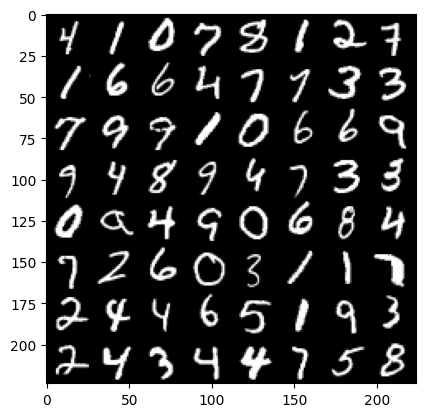

[[4 1 0 7 8 1 2 7]
 [1 6 6 4 7 7 3 3]
 [7 9 9 1 0 6 6 9]
 [9 4 8 9 4 7 3 3]
 [0 9 4 9 0 6 8 4]
 [7 2 6 0 3 1 1 7]
 [2 4 4 6 5 1 9 3]
 [2 4 3 4 4 7 5 8]]


In [97]:
import matplotlib.pyplot as plt
import numpy as np

img0 = image[:64].reshape(8,8,28,28)
print(img0.shape)
img0 = np.transpose(img0, axes=(0,2,1,3)).reshape(8*28, 8*28)
plt.imshow(img0, cmap="gray")
plt.show()
print(label[:64].reshape(8,8))

In [ ]:
image.shape, label.shape

((64, 28, 28, 1), (64,))

## Feladat: Kategorizáljuk a képeket
## Hogyan lehet ilyesmit leprogramozni?

Az első ötletünk az lehet, hogy próbáljuk megérteni, mitől érzékelünk egy képet 1-esnek, 2-esnek, stb. majd ezt valahogy formalizáljuk végül lekódoljuk.

Ez teljesen reménytelennek tűnik. Ehelyett inkább olyan eljárást keresünk, ami egy könnyen számolható függvény osztályból kiválaszt egyet, ami az esetek többségében jól működik.

#### Milyen függvény osztályok jöhetnek szóba?

A függvény bemenete egy kép, jelen esetben szürkeárnyalatos 28x28 pixeles kép. Azaz minden bemenet 28x28 intenzitás értékkel van megadva.
Erre gondolhatunk úgy, hogy egy 784 dimenziós (valós) vektorra.


Mi lenne a függvény kimenete? 10 lehetséges kategória (osztály) között kell választani. Ezért a kimenet lehetne egy egész 0 és 9 között, de egyszerűbb 10 értéket kiszámolni és aztán a döntés a legnagyobb érték indexe.  

Azaz keresünk egy
$$
    g:\mathbb{R}^{784} \to \mathbb{R}^{10}, \quad f = \arg\max(g)
$$

A legegyszerűbb függvények a lineáris függvények, ezek könnyen paraméterezhetőek.

Általában is függvény osztály elemeit paraméteresen adjuk meg és a paramétereket szeretnénk azonosítani.


## Paraméterek keresése, veszteség minimalizálás

Mikor gondolnánk egyik függvényt jobbnak mint a másikat? Nyilván akkor, ha több helyest döntést hoz. Azaz $g_0(x_i),\dots,g_9(x_i)$ értékek
közül az esetek többségében az $y_i$ indexű a legnagyobb, ahol $(x_i,y_i)$ az ismert input-output párokat jelöli.

Egy lehetséges kritérium, hogy az $y_i$ indexet 0-1 vektorként kódoljuk $z_i=(\mathbb{1}_{k=y_i})_{k=0}^9$ és olyan $g$-t keresünk, amire
$$
    \sum_i \|g(x_i) - z_i\|^2
$$
minimális.

Egy másik lehetőség lehetne, hogy a
$$
    \sum_i \sum_k (2z_{i,k}-1)*g_k(x_i)
$$
kifejezést próbálnánk maximalizálni. Ezzel az a gond, hogy felülről nem feltétlenül korlátos.

Egy további lehetőség lehetne, hogy a
$$
    \sum_i \sum_k \max(1-(2z_{i,k}-1)*g_k(x_i),0)
$$
minimalizálása, vagy
$$
    \sum_i -\log p_{y_i}(x_i), \quad p_k(x)=\frac{e^{g_k(x)}}{\sum_\ell e^{g_\ell(x)}}
$$
minimalizálása.

Ezekben az a közös, hogy megfogalmazhatóak egy ($x$-ben differenciálható) veszteség minimalizálásaként.


## Gradiens ereszkedés (Gradient descent)
Néhány esetben a megoldás kifejezhető az $(x_i, y_i)$ párok segítségével, de még ezekben az esetekben is inkább általános iterative eljárást szoktak használni.

A $g(x)$ valójában $g(x,\vartheta)$, ahol $\vartheta$ a függvény megadására szolgáló paraméter vektor. pl. ha $g$ lineáris, akkor
$$
    g(x) = b + Ax,\quad \vartheta=(b, A),\quad b\in\mathbb{R}^{10},\quad A\in\mathbb{R}^{10\times 784}, \quad x\in\mathbb{R}^{784}
$$

Azaz $g$ a paraméter szerint is deriválható. Ha $\ell$ jelöli a veszteség függvényt, akkor
$$
    \hat\vartheta = \arg\min_{\theta}L(\vartheta), \quad L(\vartheta) = \frac1n\sum_{i} \ell (g(x_i,\vartheta), y_i)
$$
úgy is számolható, hogy
$$
    \vartheta_{n+1} = \vartheta_n -\eta L'(\vartheta_n)
$$
ahol $\eta$ általában egy kicsi szám, a tanulási ráta. Mindig abba az irányba próbáljuk $\vartheta_n$-t módosítani amerre a leginkább csökken.
Ezt a minimalizálási eljárást gradiens ereszkedésnek hívják.

Gyakran nem kell $L'$-t pontosan számolni elegendő az adatok egy $b$ részét használni, Azaz $L'$ helyett $L'_b$-t használjuk, ahol
$$
    L'_b(\vartheta)=\frac{1}{|b|}\sum_{i\in b} \partial_\vartheta\ell(g(x_i, \vartheta), y_i)
$$

Szerencsére a derivált számolást nem kell leprogramozni. A neurális hálós keretrendszerek mind megteszik ezt nekünk. Mi a `jax` könytárat fogjuk használni.



In [ ]:
try:
    import jax
except ModuleNotFoundError:
    ! pip install jax[cpu]


In [ ]:
from jax import grad
import jax.numpy as jnp

def tanh(x):  # Define a function
  y = jnp.exp(-2.0 * x)
  return (1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)  # Obtain its gradient function
print(grad_tanh(1.0))   # Evaluate it at x = 1.0
# prints 0.4199743

0.4199743


In [ ]:
import jax
import jax.numpy as jnp

In [ ]:
def g(theta, x):
    x = x.reshape(-1)
    b, A = theta
    return b + A @ x

def f(g):
    return g.argmax()

theta = np.random.normal(size=10), np.random.normal(size=(10, 784))

In [ ]:
x = image[0]
pred = g(theta, x)
print(f'{pred}\nA képen {f(pred)} van?')

[ 1590.63483355  -409.04902224 -2210.17726897  -854.70771349
  -374.97502375   839.64554984   697.20843794  -647.81655997
  -812.55486051  -391.35935343]
A képen 0 van?


Szerencsésebb lenormálni az $A$ mátrixot, és a képet is.

In [ ]:
image[0].max()

255

In [ ]:
def g(theta, x):
    x = x.reshape(-1)/255
    b, A = theta
    return b + A @ x

def f(g):
    return g.argmax()

theta = np.random.normal(size=10), (784**(-0.5))*np.random.normal(size=(10, 784))

[ 0.06275525 -0.30588212 -0.78621068  0.80639652 -0.50387306  0.77568714
  0.26752257 -1.06806978 -0.18128011  1.10769932]
A képen 9 van?


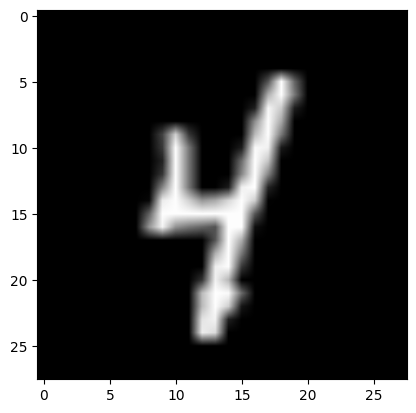

In [ ]:

x = image[0]
pred = g(theta, x)
print(f'{pred}\nA képen {f(pred)} van?')
plt.imshow(x.squeeze(), cmap='gray', interpolation='bilinear')

## Veszteség függvény

Válasszuk a keresztentrópiát:
$$
    \sum_i -\log p_{y_i}(x_i)=\sum -g_{y_i}(x_i)+\log(\sum_je^{g_j(x_i)}), \quad p_k(x)=\frac{e^{g_k(x)}}{\sum_j e^{g_j(x)}}
$$

In [ ]:
def ell(pred, y):
    return jax.nn.log_softmax(pred) @ y

def ell(pred, y):
    return -pred@y + jax.nn.logsumexp(pred)


In [ ]:
y = jax.nn.one_hot(label[0], 10)
pred = g(theta, x)
log_p = jax.nn.log_softmax(pred)
print(f'pred: \t{pred}\none-hot:\t{y}\nlog p:\t{log_p}\nloss:\t{ell(pred, y)}')

pred: 	[ 0.06275525 -0.30588212 -0.78621068  0.80639652 -0.50387306  0.77568714
  0.26752257 -1.06806978 -0.18128011  1.10769932]
one-hot:	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
log p:	[-2.485508  -2.8541453 -3.3344738 -1.7418666 -3.0521362 -1.7725761
 -2.2807407 -3.616333  -2.7295432 -1.4405639]
loss:	3.052136182785034


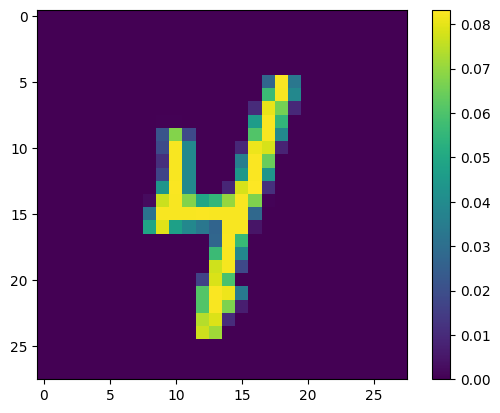

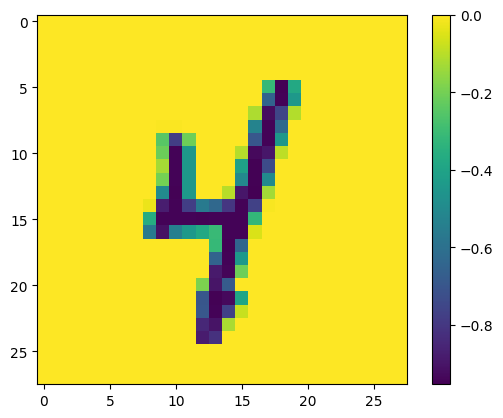

In [ ]:
def L(theta, x, y):
    pred = g(theta, x)
    return ell(pred, y)

dL = grad(L)

dx, dA = dL(theta, x, y)

plt.imshow(dA[0].reshape(28,28))
plt.colorbar()
plt.show()

plt.imshow(dA[4].reshape(28,28))
plt.colorbar()
plt.show()

In [ ]:
batch_L = jax.vmap(L, in_axes=None)
batch_L(theta, x=image[:16]/255, y=jax.nn.one_hot(label[:16], 10))


Array([3.0317714, 2.6231654, 2.4849973, 3.186398 , 2.6376731, 2.6217399,
       2.8996954, 3.1870904, 2.6229334, 2.6155155, 2.6148243, 3.0323372,
       3.187337 , 3.1858852, 1.9592934, 1.9594262], dtype=float32)

In [ ]:
def loss_fn(theta, x, y):
    return batch_L(theta, x=x, y=y).mean(axis=0)

loss_fn = jax.value_and_grad(loss_fn)

def training_step(theta, x, y, eta):
    y = jax.nn.one_hot(y, 10)
    loss, gradient = loss_fn(theta, x=x, y=y)
    return loss, jax.tree_map(lambda t, g: t-eta*g, theta, gradient)

In [ ]:
# loss_fn(theta, x=image[:16]/255, y=jax.nn.one_hot(label[:16], 10))
loss, gradient = training_step(theta, x=image[:16], y=label[:16], eta=0.1)

In [ ]:
gradient

(Array([ 0.04039143, -0.08465971, -0.37032005,  0.56164116, -0.4988834 ,
         0.74014133, -0.08344006, -0.63771945, -0.10998477,  1.0885104 ],      dtype=float32),
 Array([[-0.00998578,  0.00675734,  0.0182924 , ..., -0.04826672,
         -0.01432063, -0.06809822],
        [-0.00448857, -0.05447214, -0.06888043, ...,  0.04378104,
         -0.00382151, -0.02001577],
        [ 0.03399074, -0.01033012,  0.05520532, ..., -0.02236073,
          0.0034304 , -0.07822824],
        ...,
        [ 0.04488443,  0.0368625 ,  0.05039056, ...,  0.02955437,
          0.03280777, -0.04749516],
        [-0.00019675, -0.00075679, -0.05683504, ...,  0.01868623,
          0.04344809,  0.03190525],
        [-0.00857083,  0.02080895,  0.00812556, ..., -0.01349704,
         -0.01586417, -0.00822333]], dtype=float32))

In [ ]:
theta = theta = 0.1 * np.random.normal(size=10), (784**(-0.5))*np.random.normal(size=(10, 784))
eta = 0.1
losses = []

for i, example in tqdm(enumerate(train.repeat().shuffle(10000).batch(256).take(2000).as_numpy_iterator())):
    img, label = example['image'], example['label']
    loss, theta = training_step(theta, img, label, eta)
    losses.append(loss)
    if (i+1) % 200==0:
        eta *= 0.5

0it [00:00, ?it/s]

2024-12-04 12:59:15.844738: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-04 12:59:46.829056: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
eta

9.765625e-05

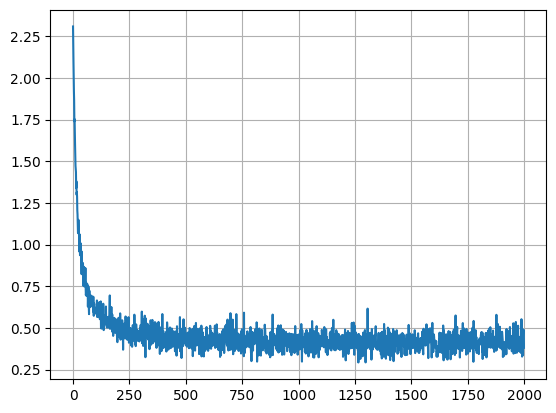

In [ ]:
plt.plot(losses)
plt.grid()
plt.show()

In [ ]:
def predict(theta, x):
    return jax.vmap(g, in_axes=None)(theta, x=x).argmax(axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def cm_(y_true, y_pred, classes=None):
    if classes is None:
        classes = np.unique(y_true)
    cm = pd.DataFrame(
        confusion_matrix(
            y_pred=y_pred,
            y_true=y_true,
            labels=classes
            ),
            columns=classes,
            index=classes)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    return cm


In [ ]:
preds = []
labels = []
for example in test.batch(256).as_numpy_iterator():
    img, label = example['image'], example['label']
    preds.append(predict(theta, x=img))
    labels.append(label)
preds = np.concatenate(preds)
labels = np.concatenate(labels)
print('test tévesztési mátrix')
cm_(y_pred=preds, y_true=labels)
#confusion_matrix(y_pred=preds, y_true=label, labels=range(10))

test tévesztési mátrix


2024-12-04 12:59:49.260227: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,904,0,7,5,2,11,12,2,15,1
1,1,1090,7,7,1,5,1,3,13,1
2,7,14,862,10,23,3,20,27,30,3
3,7,4,22,889,1,35,4,12,26,17
4,2,11,11,0,894,2,9,1,7,50
5,21,10,8,41,20,715,20,6,51,20
6,5,5,10,2,12,16,930,0,8,0
7,7,20,17,1,17,0,0,964,1,30
8,7,33,23,35,9,23,6,7,808,22


In [ ]:
preds = []
labels = []
for example in train.batch(256).as_numpy_iterator():
    img, label = example['image'], example['label']
    preds.append(predict(theta, x=img))
    labels.append(label)
preds = np.concatenate(preds)
labels = np.concatenate(labels)
print('train tévesztési mátrix')
cm_(y_pred=preds, y_true=labels)


train tévesztési mátrix


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4746,0,20,19,13,41,54,6,58,7
1,0,5413,22,24,3,44,11,12,75,9
2,50,70,4204,86,115,15,113,105,162,39
3,25,39,136,4390,6,218,43,71,118,68
4,9,27,36,5,4378,5,68,13,44,270
5,92,65,36,213,71,3603,100,25,215,89
6,47,23,65,3,38,77,4621,2,54,0
7,43,82,86,23,80,8,3,4656,22,205
8,29,152,71,160,19,155,42,33,4113,104


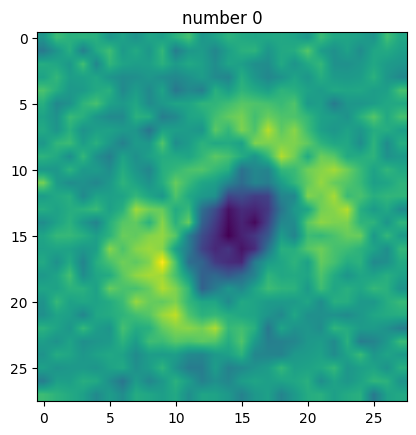

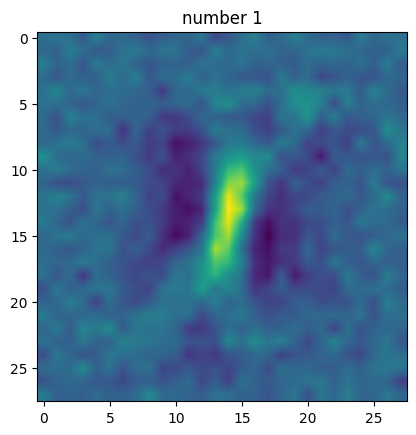

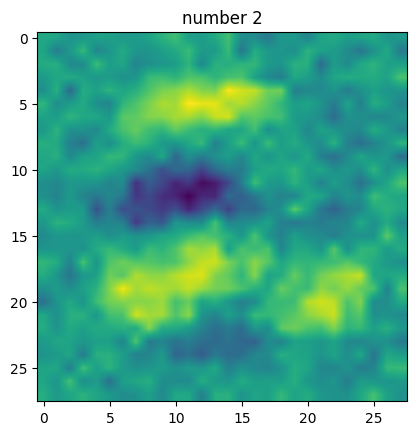

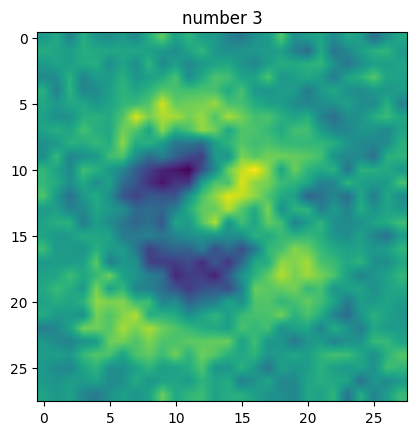

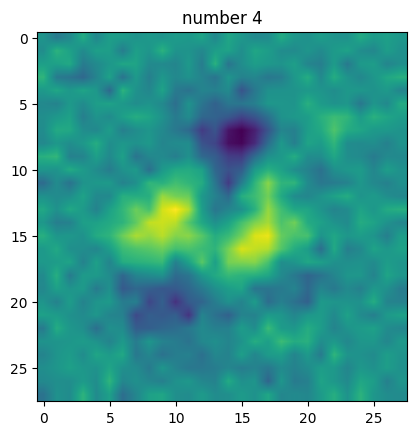

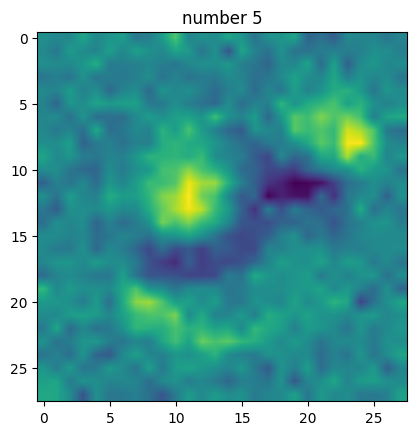

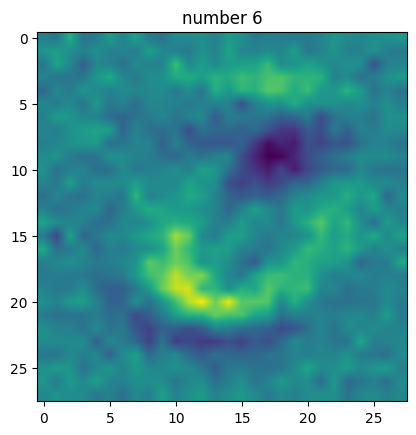

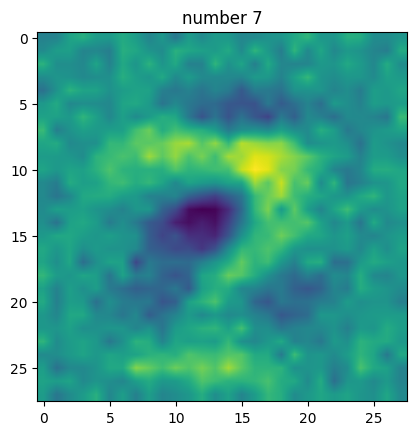

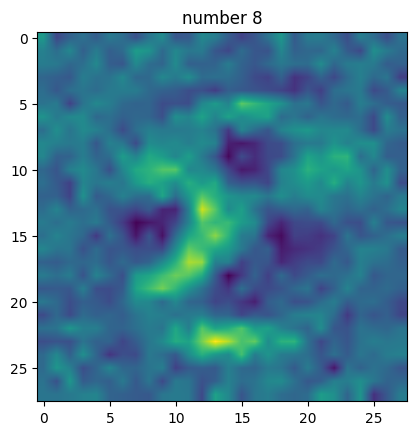

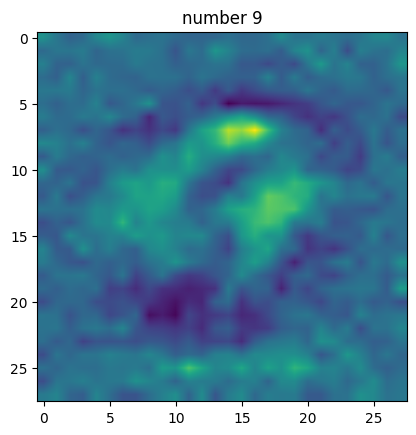

In [ ]:
b, A = theta
for i, row in enumerate(A):
    plt.imshow(row.reshape(28, 28), interpolation='bilinear')
    plt.title(f'number {i}')
    plt.show()

## Több rétegű neurális háló

Lineáris függvények családja nagyon szűk.

Az derül ki, hogy ha $g_1\circ \sigma\circ g_2$ alakban már tetszőleges (folytonos) függvény közelíthető, ha a közepső tér dimenziója elég nagy és
$\sigma$ egy koordinátánként számolt nem lineáris **aktivációs** függvény. Szokásos választások $\sigma$-ra $\sigma(x)=\max(x,0)$,  vagy $\sigma(x)=\tanh(x)$, vagy $\sigma(x)=1/(1+e^{-x})$ (mindegyik koordinátánként értendő).

A következő rész a `jax` dokumentációjában szereplő példa.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/Neural_Network_and_Data_Loading.ipynb)

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

A véletlen számokat a `jax` rendszer kicsit másképp kezeli. A véletlenszám generátornak mindig meg kell adni egy kulcsot (a generátor állapotát).
Új véletlenszám generálása előtt a kulcsot szét kell bontani, az egyikből az aktuális érték(ek)et szzámoljuk, a másikból a következőket.

In [ ]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
params = init_network_params(layer_sizes, random.PRNGKey(0))

A `predict` függvény hasonló a fentihez, de most minden (rejtett) réteg után alkalmazunk egy `relu` (rectified linear unit, igazából pozitív rész) nem linearitást, vagy aktivációs függvényt.

In [ ]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image.flatten()/255.0
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)

  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

In [ ]:
# This works on single examples
preds = predict(params, image[0])
print(preds.shape)
print(preds)

(10,)
[-2.2953994 -2.2987492 -2.2974277 -2.318979  -2.3008723 -2.3090346
 -2.3071167 -2.3012722 -2.3021984 -2.2950432]


Ugyanúgy mint a lineáris esetben a `predict` függvény nem képes több képet egyszerre kezelni.

In [ ]:
try:
  preds = predict(params, image[:10])
except TypeError:
  print('Invalid shapes!')

Invalid shapes!


A `vmap` transzformáció most is segít.

In [ ]:
batched_predict = vmap(predict, in_axes=(None, 0))

batched_preds = batched_predict(params, image[:8])
print(batched_preds.shape)

(8, 10)


In [ ]:
n_targets = 10

In [ ]:
def y_pred_true(f, params, dataset):
    y_pred = []
    y_true = []
    for example in tqdm(dataset.batch(256).as_numpy_iterator()):
        images, targets = example['image'], example['label']
        y_pred.append(f(params, images).argmax(axis=-1))
        y_true.append(targets)
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    return {'y_pred': y_pred, 'y_true':y_true}

def accuracy(f, params, dataset):
    y = y_pred_true(f, params, dataset)
    acc = sum(y['y_pred'] == y['y_true'])
    n = len(y['y_pred'])
    return acc/n

def loss(params, images, targets):
    targets = jax.nn.one_hot(targets, n_targets)
    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)*n_targets

@jit
def update(params, x, y, step_size):
    grads = grad(loss)(params, x, y)
    return jax.tree_map(lambda p, g: p - step_size * g, params, grads)


Konstansok:

In [ ]:
step_size = 0.1
num_epochs = 8
batch_size = 128


In [ ]:
import time

lr = jnp.array(step_size)
for epoch in range(num_epochs):
  start_time = time.time()
  for example in tqdm(train.shuffle(5000).batch(128).as_numpy_iterator()):
    x, y = example['image'], example['label']
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(batched_predict, params, train)
  test_acc = accuracy(batched_predict, params, test)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

0it [00:00, ?it/s]

2024-12-04 12:59:55.954498: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 0 in 2.15 sec
Training set accuracy 0.83628
Test set accuracy 0.8407


0it [00:00, ?it/s]

0it [00:00, ?it/s]

2024-12-04 13:00:05.524319: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0it [00:00, ?it/s]

Epoch 1 in 1.93 sec
Training set accuracy 0.90714
Test set accuracy 0.9065


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 2 in 1.85 sec
Training set accuracy 0.92994
Test set accuracy 0.9278


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 3 in 2.46 sec
Training set accuracy 0.94644
Test set accuracy 0.9413


0it [00:00, ?it/s]

2024-12-04 13:00:19.325848: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 4 in 1.75 sec
Training set accuracy 0.95902
Test set accuracy 0.9554


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 5 in 1.69 sec
Training set accuracy 0.9608
Test set accuracy 0.9537


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 6 in 1.65 sec
Training set accuracy 0.96664
Test set accuracy 0.9606


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 7 in 1.68 sec
Training set accuracy 0.97592
Test set accuracy 0.9668


In [ ]:
train_y = y_pred_true(batched_predict, params, train)
cm_(train_y['y_pred'], train_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4888,0,5,2,2,8,12,2,6,9
1,1,5544,14,4,12,5,6,20,28,11
2,12,17,4850,37,5,3,3,35,9,0
3,13,15,34,5003,3,89,1,8,42,63
4,1,4,10,0,4744,5,11,18,6,67
5,5,1,0,21,2,4332,15,3,10,18
6,18,6,8,0,23,22,4872,0,11,2
7,1,6,17,13,5,2,0,5087,1,44
8,22,18,18,27,8,32,10,8,4756,36


In [ ]:
test_y = y_pred_true(batched_predict, params, test)
cm_(test_y['y_pred'], test_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,936,1,2,0,1,6,3,1,2,3
1,0,1101,4,0,4,1,3,1,11,5
2,1,8,965,8,2,2,1,6,0,1
3,2,6,12,990,0,25,0,5,14,13
4,1,2,5,0,962,2,9,1,2,19
5,2,0,0,5,1,858,5,1,1,1
6,5,0,2,0,4,5,965,0,6,0
7,0,5,6,3,3,2,0,1035,2,9
8,8,6,3,9,1,6,2,0,932,4


## Konvolúciós háló

Az ötlet az, hogy a kép kis részeit tekintsük, pl. az összes 5*5-ös részképet és mindegyikre ugyanazt a lineáris leképezést alkalmazzuk, majd az eredményekre az aktivációs függvényt. Ezzel kapunk egy másik (gyakran kisebb) képet ahol, nem 1 vagy 3 ,,szín'' van, hanem sok, attól függően, hogy hány ismérvet számolunk ki a kis képből. Ezzel a kép lokális tulajdonságait lehet kigyűjteni (van vonal vagy nincs, annak az iránya stb). Ilyen rétegeket pakolunk egymásra és a végén a kapott képre az imént látott összegzést alkalmazzuk.



In [ ]:
try:
    import haiku as hk
except ModuleNotFoundError:
    ! pip install dm-haiku

In [ ]:
hk.MaxPool?

Init signature:
hk.MaxPool(
    window_shape: Union[int, collections.abc.Sequence[int]],
    strides: Union[int, collections.abc.Sequence[int]],
    padding: str,
    channel_axis: Optional[int] = -1,
    name: Optional[str] = None,
)
Docstring:     
Max pool.

Equivalent to partial application of :func:`max_pool`.
Init docstring:
Max pool.

Args:
  window_shape: Shape of the pooling window, same rank as value.
  strides: Strides of the pooling window, same rank as value.
  padding: Padding algorithm. Either ``VALID`` or ``SAME``.
  channel_axis: Axis of the spatial channels for which pooling is skipped.
  name: String name for the module.
File:           ~/.config/jupyterlab-desktop/jlab_server/envs/python3.10/lib/python3.10/site-packages/haiku/_src/pool.py
Type:           ModuleMetaclass
Subclasses:     


In [ ]:
hk.transform?

Signature: hk.transform(f, *, apply_rng=True) -> haiku._src.transform.Transformed
Docstring:
Transforms a function using Haiku modules into a pair of pure functions.

For a function ``out = f(*a, **k)`` this function returns a pair of two pure
functions that call ``f(*a, **k)`` explicitly collecting and injecting
parameter values::

    params = init(rng, *a, **k)
    out = apply(params, rng, *a, **k)

Note that the ``rng`` argument is typically not required for ``apply`` and
passing ``None`` is accepted.

The first thing to do is to define a :class:`Module`. A module encapsulates
some parameters and a computation on those parameters:

>>> class MyModule(hk.Module):
...   def __call__(self, x):
...     w = hk.get_parameter("w", [], init=jnp.zeros)
...     return x + w

Next, define some function that creates and applies modules. We use
:func:`transform` to transform that function into a pair of functions that
allow us to lift all the parameters out of the function (``f.init``) and
appl

In [ ]:
def lenet(x):
    x = x.astype(jnp.float32)/255
    x = hk.Conv2D(32, 5, padding='VALID')(x)
    x = jax.nn.relu(x)
    x = hk.MaxPool(2, 2, padding='VALID')(x)
    x = hk.Conv2D(64, 5, padding='VALID')(x)
    x = jax.nn.relu(x)
    x = hk.MaxPool(2, 2, padding='VALID')(x)
    x = hk.Flatten()(x)
    x = hk.Linear(128)(x)
    x = jax.nn.relu(x)
    x = hk.Linear(n_targets)(x)
    x = jax.nn.log_softmax(x)
    return x


In [ ]:
param_init, lenet_apply = hk.transform(lenet)
def lenet_fn(params, images):
    return lenet_apply(params, None, images)

In [ ]:
key = jax.random.PRNGKey(0)
params = param_init(key, image[:10])

In [ ]:
lenet_apply(params, None, image[:1])

Array([[-2.4083664, -2.1603966, -2.3317041, -2.5491571, -2.2276087,
        -2.2106547, -2.1173048, -2.474362 , -2.3706279, -2.2626748]],      dtype=float32)

In [ ]:

def lenet_loss(params, images, targets):
  targets = jax.nn.one_hot(targets, n_targets)
  preds = lenet_apply(params, None, images)
  return -jnp.mean(preds * targets)*n_targets

@jit
def lenet_update(params, x, y, step_size):
  grads = grad(lenet_loss)(params, x, y)
  return jax.tree_map(lambda p, g: p - step_size * g, params, grads)


In [ ]:
import time

lr = jnp.array(step_size)

for epoch in range(num_epochs):
  start_time = time.time()
  for example in tqdm(train.cache().shuffle(5000).batch(128).as_numpy_iterator()):
    x, y = example['image'], example['label']
    params = lenet_update(params, x, y, lr)
  lr = lr*0.9
  epoch_time = time.time() - start_time

  train_acc = accuracy(lenet_fn, params, train)
  test_acc = accuracy(lenet_fn, params, test)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

0it [00:00, ?it/s]

2024-12-04 13:25:13.517435: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 0 in 35.64 sec
Training set accuracy 0.96614
Test set accuracy 0.9627


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1 in 35.45 sec
Training set accuracy 0.98372
Test set accuracy 0.9798


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 2 in 35.32 sec
Training set accuracy 0.98636
Test set accuracy 0.9828


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 3 in 35.36 sec
Training set accuracy 0.99064
Test set accuracy 0.9848


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 4 in 35.18 sec
Training set accuracy 0.99058
Test set accuracy 0.9838


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 5 in 35.30 sec
Training set accuracy 0.98674
Test set accuracy 0.9807


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 6 in 35.68 sec
Training set accuracy 0.99374
Test set accuracy 0.9867


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 7 in 35.34 sec
Training set accuracy 0.99488
Test set accuracy 0.9878


In [ ]:
train_y = y_pred_true(lenet_fn, params, train)
cm_(train_y['y_pred'], train_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4956,0,1,1,0,1,9,0,2,3
1,1,5587,3,0,2,0,0,2,6,1
2,0,4,4932,4,1,1,1,3,5,0
3,0,0,1,5081,0,5,0,1,4,0
4,0,2,2,0,4833,0,5,2,3,10
5,0,0,1,7,0,4488,7,0,3,3
6,1,2,1,0,2,4,4902,0,0,0
7,0,13,13,7,2,2,0,5191,4,13
8,2,4,3,5,1,2,6,2,4838,4


In [ ]:
test_y = y_pred_true(lenet_fn, params, test)
cm_(test_y['y_pred'], test_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,952,0,0,0,0,2,1,0,2,0
1,0,1114,2,0,0,0,0,1,1,0
2,0,3,979,3,2,0,1,0,1,1
3,0,0,5,1008,0,2,0,1,6,3
4,1,0,0,0,976,0,6,0,2,1
5,0,0,0,1,0,901,2,0,3,0
6,2,1,0,0,1,1,976,0,1,0
7,0,7,8,0,2,2,0,1052,1,4
8,3,2,4,2,0,2,2,0,951,1
